# Classifying Tumors in Mammograms

# Part 1A MIAS Dataset Cleaning & EDA

## Problem Statement

Breast Cancer is the second leading cause of death in women around the globe. Early detection through routine mammograms is the best prevention in improving Breast Cancer outcomes. 

For this project, we used 2 different mammogram datasets of differing sizes and built various neural network models in order to classify Tumors vs. No Tumors in mammogram images. Manual visual analysis of these images can be time consuming and subjective. This model aims to be used as a supplementary detection method for use by radiologists and oncologists.

## Contents
- [Background](#Background)
- [Image Classification Workflow](#Image-Classification-Workflow)
- [Data Dictionary](#Data-Dictionary)
- [References](#References)
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [EDA](#EDA)
- [Data Augmentation](#Data-Augmentation)

## Background

Image classification refers to the labeling of images into one of a number of predefined classes. Manually checking and classifying each image can be a tedious painstaking task especially when there are a lot of them. Our goal for this project is to automate this entire process for classifying mammogram images. We tackled a binary classification of Tumor vs. No Tumor.

Some of the issues in dealing with mammograms include the fact that x-rays are a 2D representation of 3D structures. As a result, "scan representations can be highly noisy and separation between tumorous and clear tissue can be gradual, making it hard to determine where the affected tissue begins and ends." [(Source)](https://arxiv.org/pdf/1807.03095.pdf)


### MIAS Dataset

We used 330 images from the [MiniMammographic Database](http://peipa.essex.ac.uk/info/mias.html) provided by the Mammographic Image Analysis Society (MIAS). The original MIAS Database (digitized at 50 micron pixel edge) has been reduced to 200 micron pixel edge and clipped/padded so that every image is 1024 pixels x 1024 pixels. 

**Notes:**
- The list was arranged in pairs of films, where each pair represents the left (even filename numbers) and right mammograms (odd filename numbers) of a single patient. 
- The size of all the images provided was 1024 pixels x 1024 pixels. The images were centered in the matrix.
- When calcifications are present, centre locations and radii apply to clusters rather than individual calcifications. Coordinate system origin is the bottom-left corner.
- In some cases calcifications are widely distributed throughout the image rather than concentrated at a single site. In these cases centre locations and radii are inappropriate and have been omitted.

**Additional Notes:**
- X,Y Origin is at the lower left of the image
- There are 330 observations in the label csv, vs 322 images.  Some images have multiple tumors.  In this case, multiple observations are entered into the label csv.
- Some images have tags and notes in the upper corners, or white bars on the edges as artifacts from the physical copy.

## Image Classification Workflow

1. **Image preprocessing** is a key step before modeling in order to improve the image data (features) by suppressing unwanted distortions and enhancement of some important image features so that our models can benefit from this improved data to work on. Data augmentation is a way of creating new 'data' with different orientations. The benefits of this are two-fold, the first being the ability to generate 'more data' from limited data and secondly, it prevents overfitting.
    - Read image
    - Resize image
    - Data Augmentation Methods that were explored
        - Gray scaling of image
        - Reflection - flip images horizontally and vertically
        - Histogram Equalization - increase global contrast of an image using the image intensity histogram
        - Rotation - Form of upsampling your dataset since it creates rotated copies of the same image.
        - Translation
        - Cropping - A lot of pixels are background pixels which bring no information. To avoid the proportion of mass pixels from being underrepresented images can be cropped around the ROI (region of interest ie. breast masses).
    
    
2. **Detection of the object(s) of interest (tumors)** will rely on the segmentation of the image and identifying the position of these tumors. 
3. **Feature extraction and training** is a crucial step wherein statistical or deep learning methods are used to identify the most interesting patterns of the image, features that might be unique to a particular class and that will, later on, help the model to differentiate between different classes and learn the features from the dataset.
4. **Classification of the object(s)** categorizes detected tumors into predefined classes by using a suitable classification technique that compares the image patterns with the target patterns.

## Data Dictionary


Labels|Description
---------|-----------
    ID                   |   MIAS image reference number.
    bg                         |   Character of background tissue.
    ab_type                  |   Class of abnormality present.
    diagnosis                |   Severity of abnormality (0:Benign, 1:Malignant).
    ab_x                |   Image x-coordinate of center of abnormality.
    ab_y                    |   Image y-coordinate of center of abnormality.
    ab_r                 |   Approximate radius (in pixels) of a circle enclosing the abnormality.
    
**Sub-Classes of Certain Columns**

2nd column: Character of background tissue:
- F  Fatty
- G  Fatty-glandular
- D  Dense-glandular
  
3rd column: Class of abnormality present:
- CALC  Calcification
- CIRC  Well-defined/circumscribed masses
- SPIC  Spiculated masses
- MISC  Other, ill-defined masses
- ARCH  Architectural distortion
- ASYM  Asymmetry
- NORM  Normal
  
4th column: Severity of abnormality
- B  Benign
- M  Malignant

## References
1. MIAS Data Source: http://peipa.essex.ac.uk/info/mias.html
2. DDSM Data Source: https://www.kaggle.com/skooch/ddsm-mammography
3. CBIS-DDSM Data Source (EDA): https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM
3. https://www.kaggle.com/kmader/mias-mammography
4. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5954872/
5. https://pubmed.ncbi.nlm.nih.gov/24209932/
6. https://core.ac.uk/download/pdf/21748057.pdf
7. https://www.nature.com/articles/sdata2017177

## Data Import & Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
import glob


### Pull in images and labels
- add column 'tumor' as a binary 1 or 0 for if there's a tumor present or not
- add a 'N' for none in the diagnosis column if no tumor present (replacing Null)

Update the file location for the images as needed

The labels come from the csv 'info_red.csv' in the 'mias_data' folder

In [2]:
# check to make sure that the file_location matches the folder where the images are stored
# the file string must end with /mdb* to pull in the pictures correctly
file_location = 'mias_data/all-mias/mdb*'  # we read the file from the location that is given to us depinding on the folder have the data 

In [3]:
images = [] # make an empty list named images 
labels = [] # make an empty list named labels
files = glob.glob(file_location)  
for file in files:
    image = cv2.imread(file,0)
    images.append(image)

In [4]:
labels = pd.read_csv('mias_data/all-mias/info_red.csv',delimiter=',',names=['ID','bg','ab_type','diagnosis','ab_x','ab_y','ab_r'])

labels['diagnosis'].fillna('N',inplace=True)
labels['tumor'] = labels['diagnosis'].map(lambda x: 0 if x == 'N' else 1)
#labels['ID'] = labels['ID'].map(lambda x: x[3:])
# labels['ab_x'].fillna(512,inplace=True)
# labels['ab_y'].fillna(512,inplace=True)
# labels['ab_r'].fillna(0,inplace=True)
# labels.drop_duplicates(subset='ID', inplace = True)
#print(len(tumor))
#print(tumor)

### First ten images in the data set:

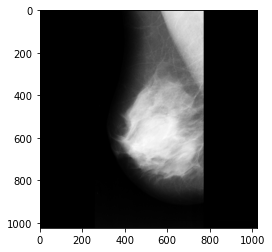

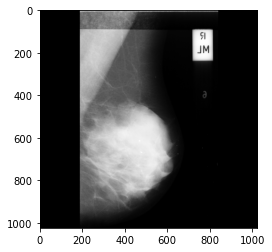

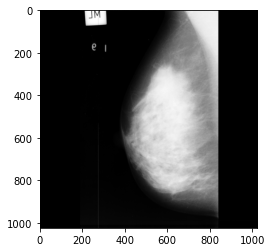

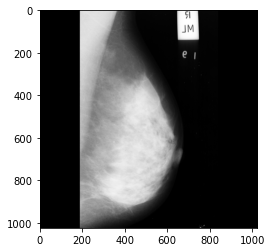

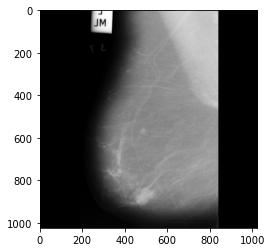

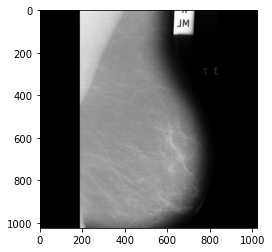

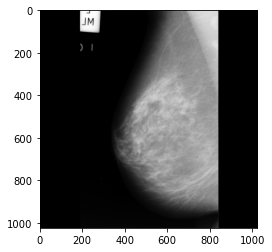

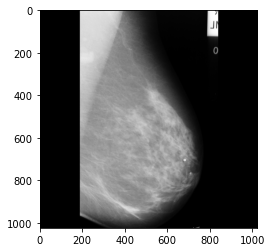

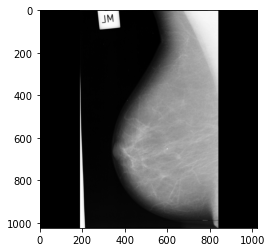

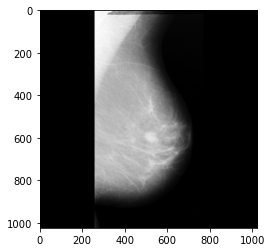

In [5]:
for i in range(10):
    plt.imshow(images[i],cmap=plt.get_cmap('gray'))
    plt.show()

## EDA

In [6]:
labels.head()
print(len(labels['tumor']))
print(labels['tumor'])

330
0      1
1      1
2      0
3      0
4      1
      ..
325    0
326    0
327    0
328    0
329    0
Name: tumor, Length: 330, dtype: int64


In [7]:
labels['tumor'].value_counts(normalize=True)
print(len(labels['tumor']))
print(labels['tumor'])

330
0      1
1      1
2      0
3      0
4      1
      ..
325    0
326    0
327    0
328    0
329    0
Name: tumor, Length: 330, dtype: int64


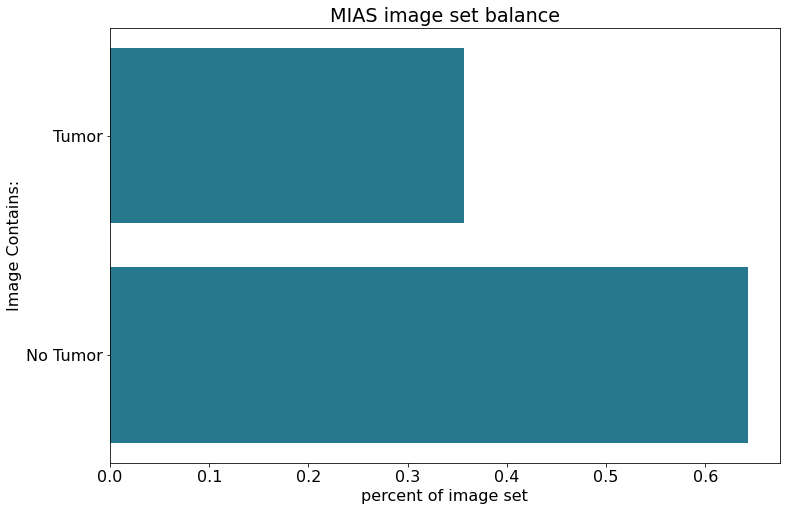

In [8]:
# determine between tumor and no tumor data
# Remove duplicate data for this binary comparison

temp_df = pd.DataFrame()
temp_df = labels.drop_duplicates(subset='ID')
height = list(temp_df['tumor'].value_counts(normalize=True))
bar_names = []
for index_item in list(temp_df['tumor'].value_counts(normalize=True).index):
    if index_item == 1:
        bar_names.append('Tumor')
    else:
        bar_names.append('No Tumor')


# Generate Graph
plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (12,8))

plt.barh(bar_names, height, color = (38/255,120/255,142/255))
 
plt.title('MIAS image set balance')
plt.xlabel('percent of image set')
plt.ylabel('Image Contains:')

plt.show()

In [9]:
labels['ab_type'].value_counts(normalize = True)
print(len(labels['tumor']))
print(labels['tumor'])

330
0      1
1      1
2      0
3      0
4      1
      ..
325    0
326    0
327    0
328    0
329    0
Name: tumor, Length: 330, dtype: int64


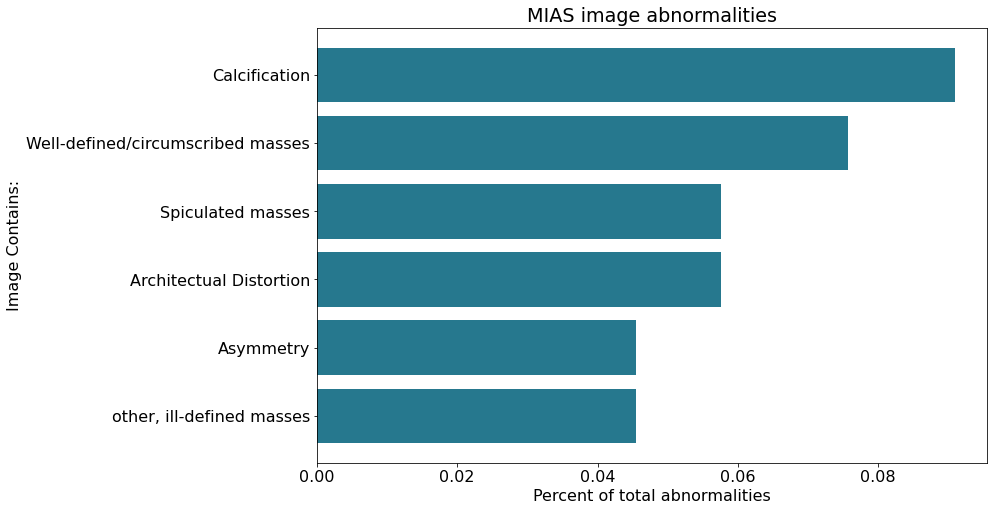

In [10]:
# dictionary to convert acronyms to full words
ab_type_conversion = {'ASYM': 'Asymmetry',
                      'MISC': 'other, ill-defined masses',
                      'ARCH': 'Architectual Distortion',
                      'SPIC': 'Spiculated masses',
                      'CIRC': 'Well-defined/circumscribed masses',
                      'CALC': 'Calcification',
                      'ASYM': 'Asymmetry',
                      'NORM': 'Normal'
                     }        
# pull out value counts, drop normal, and sort small to large
temp_df = pd.DataFrame()
temp_df = labels['ab_type'].value_counts(normalize = True).drop(index = 'NORM').sort_values()
height = list(temp_df)
# pull out names corresponding to numbers
bar_names = []
for index_item in list(temp_df.index):
    bar_names.append(ab_type_conversion[index_item])

plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (12,8))
plt.barh(bar_names, height, color = (38/255,120/255,142/255))
 
# Create names on the x-axis
#plt.yticks(y_pos, bar_names)
plt.title('MIAS image abnormalities')
plt.xlabel('Percent of total abnormalities')
plt.ylabel('Image Contains:')
# Show graphic
plt.show()

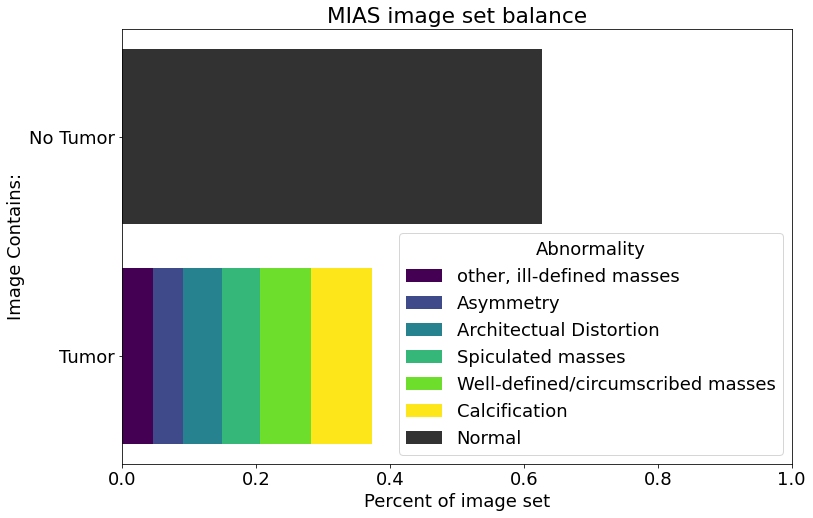

In [11]:
# pull out all normalized ab_type count values with 'NORM'
temp_df = pd.DataFrame()
temp_df = labels['ab_type'].value_counts(normalize = True).sort_values()
# append each stacked bar chart
bars = []
for num in temp_df.drop(index = 'NORM'):
    bars.append([num,0])
bars.append([0,temp_df['NORM']])

# build legend list
height = list(temp_df)
# pull out names corresponding to numbers
legend = []
for index_item in list(temp_df.index):
    legend.append(ab_type_conversion[index_item])

# Set color scheme for chart
colors1 = [(68/255,1/255,84/255),
          (62/255,74/255,137/255),
          (38/255,130/255,142/255),
          (53/255,183/255,121/255),
          (109/255,222/255,44/255),
          (253/255,231/255,27/255),
          (50/255,50/255,50/255)
         ]

colors = ['red','orange','yellow','green','blue','violet','black']

plt.rcParams.update({'font.size': 18})

# Heights of bars1 + bars2
#bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = ['Tumor', 'No Tumor']
 
# Names of group and bar width
#names = ['A','B','C','D','E']
#barWidth = 1

plt.figure(figsize = (12,8))

# Create brown bars
plt.barh(r, bars[0], color=colors1[0])
for item in range(1,7):
    plt.barh(r, bars[item], left = [sum([ x[0] for x in bars[0:item]]),0], color=colors1[item])
    
plt.title('MIAS image set balance')
plt.xlabel('Percent of image set')
plt.ylabel('Image Contains:')
plt.xlim(0, 1)

plt.legend(legend, loc = 'lower right', title = 'Abnormality')

In [12]:
labels['bg'].value_counts(normalize = True)

D    0.354545
F    0.330303
G    0.315152
Name: bg, dtype: float64

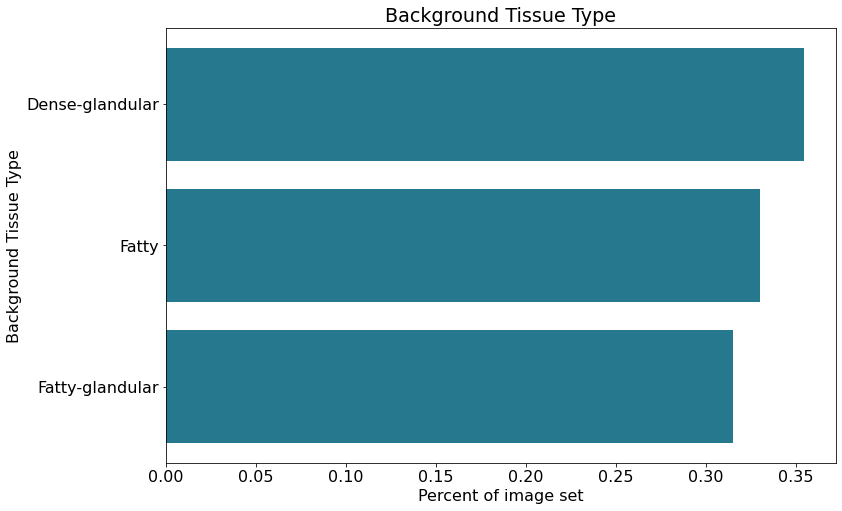

In [13]:
# conversion chart for tissue type (bg)
bg_conversion = {
    'F': 'Fatty',
    'G': 'Fatty-glandular',
    'D': 'Dense-glandular'}

# Extract normalized counts of each tissue type
temp_df = pd.DataFrame()
temp_df = labels['bg'].value_counts(normalize = True).sort_values()
# Extract column names, and convert to words
height = temp_df.values
bar_names = []
for index_item in list(temp_df.index):
    bar_names.append(bg_conversion[index_item])

# Create Graph
plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (12,8))
plt.barh(bar_names, height, color = (38/255,120/255,142/255))
 

plt.title('Background Tissue Type')
plt.xlabel('Percent of image set')
plt.ylabel('Background Tissue Type')

plt.show()

Text(0, 0.5, 'Background Tissue Type')

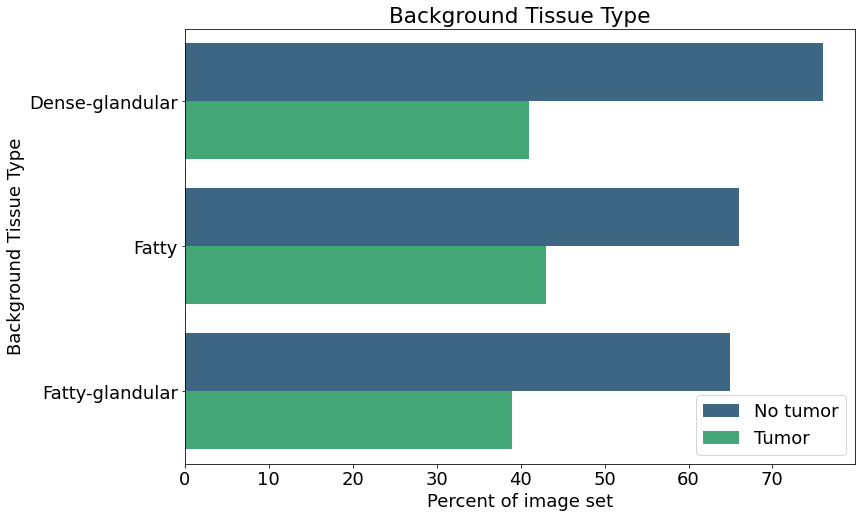

In [14]:

# Configure data frame for output
temp_df = pd.DataFrame(labels.groupby(by=['bg','tumor'])[['tumor']].count())
temp_df.rename(columns = {'tumor':'counts'}, inplace = True)
temp_df.reset_index(inplace = True)
temp_df['bg'] = temp_df['bg'].map(lambda x: bg_conversion[x])
temp_df['tumor'] = temp_df['tumor'].map(lambda x: 'Tumor' if x == 1 else 'No tumor')



# create graph
plt.rcParams.update({'font.size': 18})

plt.figure(figsize = (12,8))

sns.barplot(x="counts", y="bg", hue="tumor", data=temp_df, ci=None, palette = 'viridis');
plt.legend(loc = 'lower right')
#[(62,74,137),(109,205,89)]
#y_pos = np.arange(len(bars))

# plt.rcParams.update({'font.size': 16})

# plt.figure(figsize = (12,8))
# plt.barh(bar_names, height, color = (38/255,120/255,142/255))
 
# # Create names on the x-axis
# #plt.yticks(y_pos, bar_names)
plt.title('Background Tissue Type')
plt.xlabel('Percent of image set')
plt.ylabel('Background Tissue Type')
# # Show graphic
# plt.show()

Show images that have multiple tumors

In [15]:
# Show labels that have duplicates
labels['ID'].value_counts()[0:15]

mdb226    3
mdb144    2
mdb249    2
mdb223    2
mdb239    2
mdb005    2
mdb132    2
mdb015    1
mdb017    1
mdb160    1
mdb271    1
mdb195    1
mdb077    1
mdb013    1
mdb247    1
Name: ID, dtype: int64

## Data Augmentation
The below code rotates images and creates copies of every rotation. This was used for modeling in a different notebook.

In [16]:
# Rotating images 
#Reference: https://www.kaggle.com/codeer/mias-mammography-cnn

#######################
#print(len(labels['tumor']))
#print(labels['tumor'])
#######################

X = list(range(len(files)))
y = list(range(len(files)))
train_i, test_i, dummy_train, dummy_test = train_test_split(X,y,random_state = 42)
img_path_train = []
last_label_train = []
img_path_test = []
last_label_test = []
IMG_SIZE = 256 
print(train_i)
for i in range(len(files)):
    print(i)
    
    img = cv2.imread(files[i], 0)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    rows, cols= img.shape
    for angle in range(180):
        if i in train_i:
            
            #M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle*2, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
            img_path_train.append(img_rotated)
            
            if labels [tumor[i]] == 1:
                last_label_train.append(1)
            else:
                last_label_train.append(0)
        else:
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle*2, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
            img_path_test.append(img_rotated)
            if labels [tumor[i]] == 1:
                last_label_test.append(1)
            else:
                last_label_test.append(0)

[168, 148, 221, 227, 139, 59, 163, 6, 198, 30, 22, 274, 247, 56, 167, 145, 206, 81, 147, 39, 222, 308, 183, 152, 140, 109, 66, 199, 18, 186, 153, 19, 223, 92, 79, 124, 184, 72, 96, 15, 111, 10, 182, 69, 97, 234, 68, 23, 37, 232, 67, 258, 238, 125, 286, 86, 272, 146, 285, 262, 237, 144, 210, 155, 260, 129, 38, 224, 193, 157, 112, 211, 117, 298, 310, 292, 177, 265, 154, 203, 2, 115, 165, 202, 120, 290, 279, 127, 74, 29, 83, 267, 107, 175, 181, 133, 219, 249, 297, 65, 228, 85, 246, 159, 12, 35, 28, 170, 142, 220, 131, 194, 51, 95, 239, 178, 254, 41, 89, 250, 136, 26, 315, 141, 231, 0, 289, 304, 306, 100, 192, 277, 213, 103, 171, 98, 36, 240, 61, 150, 47, 233, 266, 11, 318, 200, 288, 27, 301, 230, 4, 122, 32, 242, 162, 282, 275, 138, 62, 215, 135, 300, 128, 312, 8, 70, 284, 64, 44, 14, 156, 40, 295, 123, 296, 278, 216, 280, 236, 207, 212, 294, 251, 313, 201, 161, 43, 217, 190, 259, 105, 53, 1, 49, 80, 205, 34, 263, 91, 52, 264, 241, 13, 88, 273, 166, 316, 134, 309, 243, 54, 50, 174, 189, 3

NameError: name 'tumor' is not defined

In [ ]:
img_path_train = np.array(img_path_train)
last_label_train = np.array(last_label_train)
img_path_test = np.array(img_path_test)
last_label_test = np.array(last_label_test)
img_path_train.shape, img_path_test.shape

In [ ]:
img_path_train = img_path_train.reshape((-1,IMG_SIZE,IMG_SIZE,1))
img_path_test = img_path_test.reshape((-1,IMG_SIZE,IMG_SIZE,1))
img_path_train.shape, img_path_test.shape

In [ ]:
last_label_train.shape, last_label_test.shape